# Train the autoencoder with the whole dataset using generators

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg

2023-04-06 18:18:07.388791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Initialize the generator and verify that it works

In [2]:
batch_size = 450
gen_input = dg.SunImgAEGenerator("data/aia_193A/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)

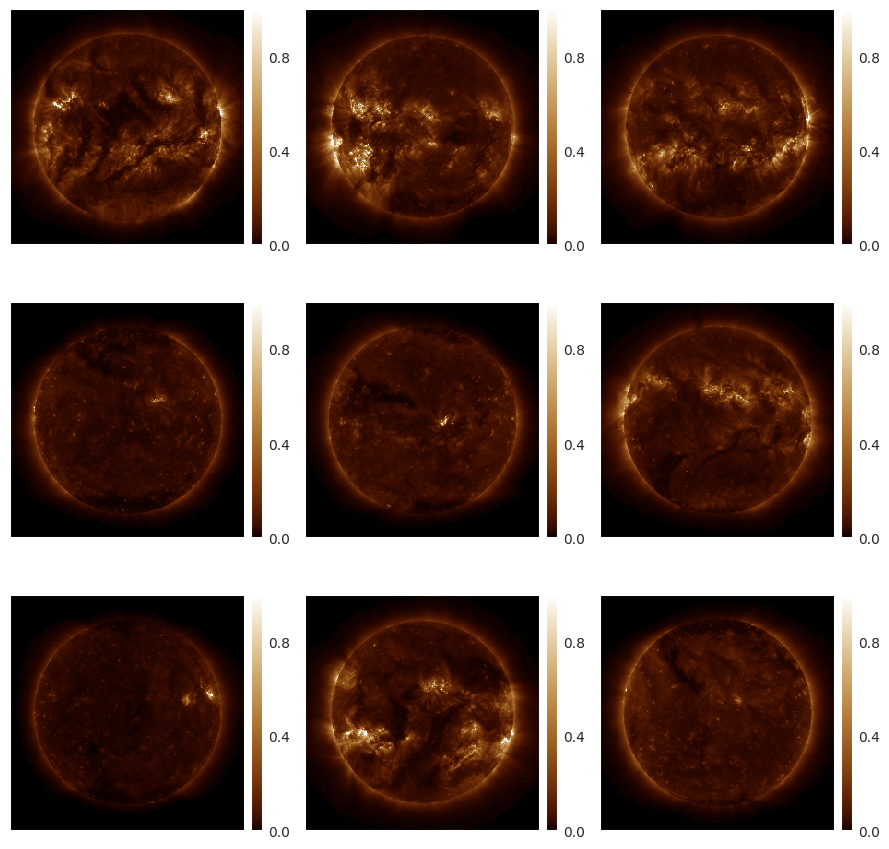

In [3]:
aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
samples = gen_input.sample(9)
isns.ImageGrid([i for i in samples], cmap=aia193_colormap)

## Create and train the model

In [4]:
latent_size = 48
autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim="adam", loss="mse")

2023-04-06 18:18:09.891489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 18:18:09.906079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 18:18:09.906262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      2320      
                                                             

In [5]:
n_epochs = 100

gen_input.training = True
history = autoencoder.fit(gen_input, epochs=n_epochs)

Epoch 1/100


2023-04-06 18:18:14.281793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-06 18:18:19.225008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-06 18:18:21.550501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-06 18:18:22.292500: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 18:18:22.516353: W tensorflow/tsl/framework/bfc_allocator.c

40/40 [==============================] - 144s 3s/step - loss: 0.0061 - mae: 0.0445
Epoch 2/100
40/40 [==============================] - 119s 3s/step - loss: 0.0037 - mae: 0.0327
Epoch 3/100
40/40 [==============================] - 119s 3s/step - loss: 0.0029 - mae: 0.0254
Epoch 4/100
40/40 [==============================] - 119s 3s/step - loss: 0.0027 - mae: 0.0239
Epoch 5/100
40/40 [==============================] - 120s 3s/step - loss: 0.0024 - mae: 0.0221
Epoch 6/100
40/40 [==============================] - 119s 3s/step - loss: 0.0023 - mae: 0.0217
Epoch 7/100
40/40 [==============================] - 118s 3s/step - loss: 0.0021 - mae: 0.0204
Epoch 8/100
40/40 [==============================] - 119s 3s/step - loss: 0.0020 - mae: 0.0204
Epoch 9/100
40/40 [==============================] - 119s 3s/step - loss: 0.0019 - mae: 0.0199
Epoch 10/100
40/40 [==============================] - 118s 3s/step - loss: 0.0019 - mae: 0.0194
Epoch 11/100
40/40 [==============================] - 119s 3s

## Save the model to a file

In [6]:
autoencoder.save("autoencoder_193A.h5")
encoder.save("encoder_193A.h5")
decoder.save("decoder_193A.h5")

## Test model and see how it progressed

2023-04-06 21:36:02.956856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/40 [==============================] - 121s 3s/step - loss: 0.0012 - mae: 0.0148


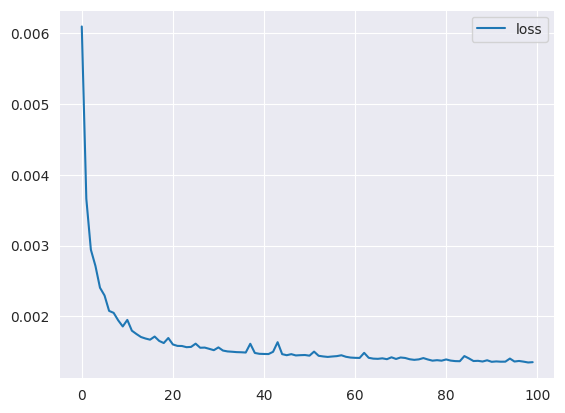

In [7]:
gen_input.training = False
autoencoder.evaluate(gen_input)
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 249ms/step


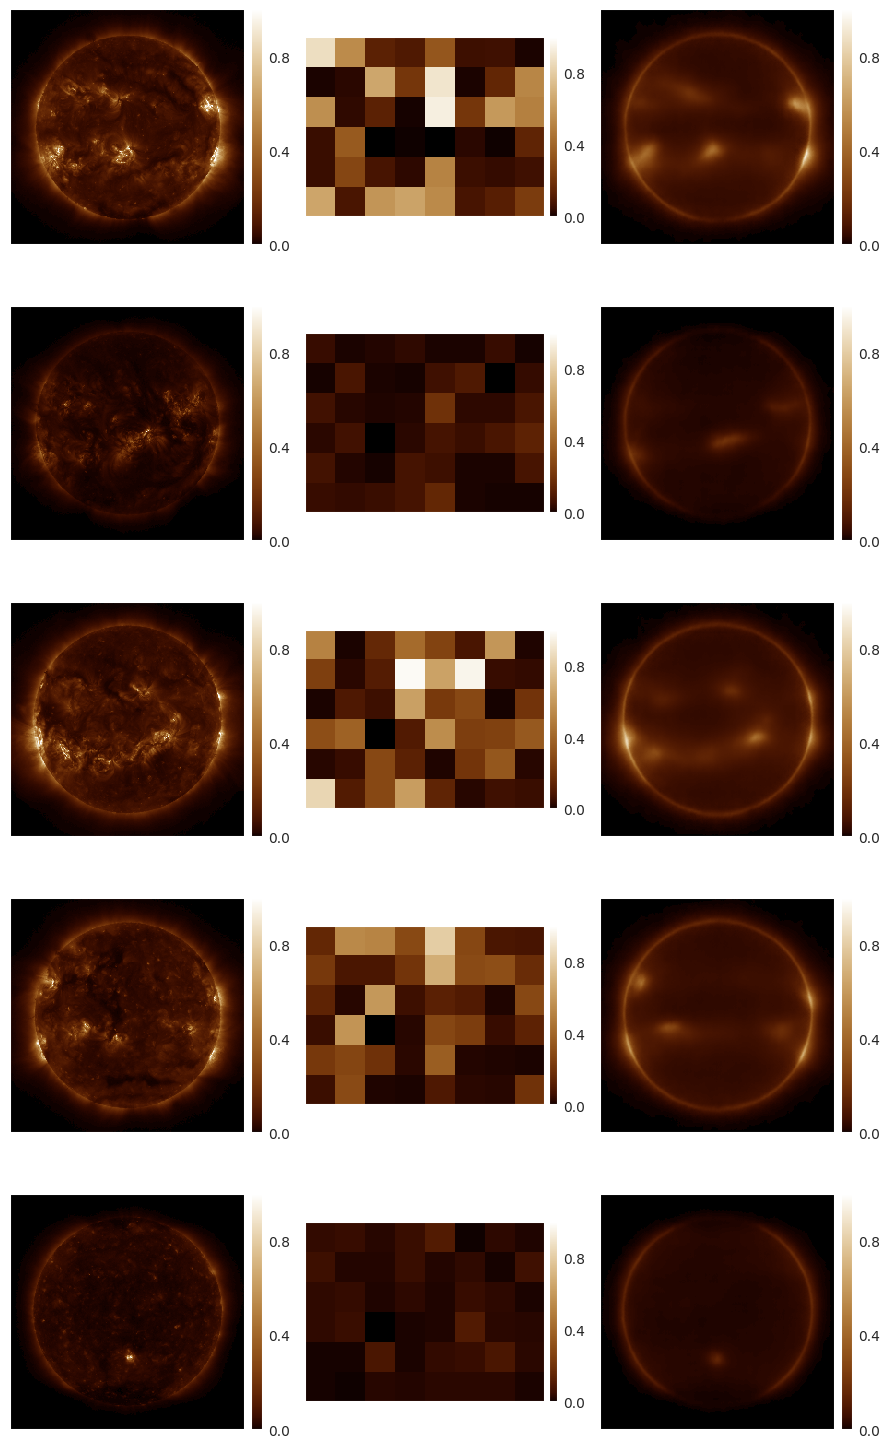

In [8]:
gen_input.training = False
example = np.array(gen_input[0]).reshape([-1,256,256,1])[:5]
code = encoder.predict(example)
reconstructed = decoder.predict(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1)

In [9]:
autoencoder = keras.models.load_model("autoencoder_193A.h5")
encoder = keras.models.load_model("encoder_193A.h5")
decoder = keras.models.load_model("decoder_193A.h5")
all_data_gen = dg.SunImgAEGenerator("data/aia_193A/", batch_size, test_split=0.2, shuffle=True, noise_filter=False)

1/1 [==============================] - 0s 52ms/step


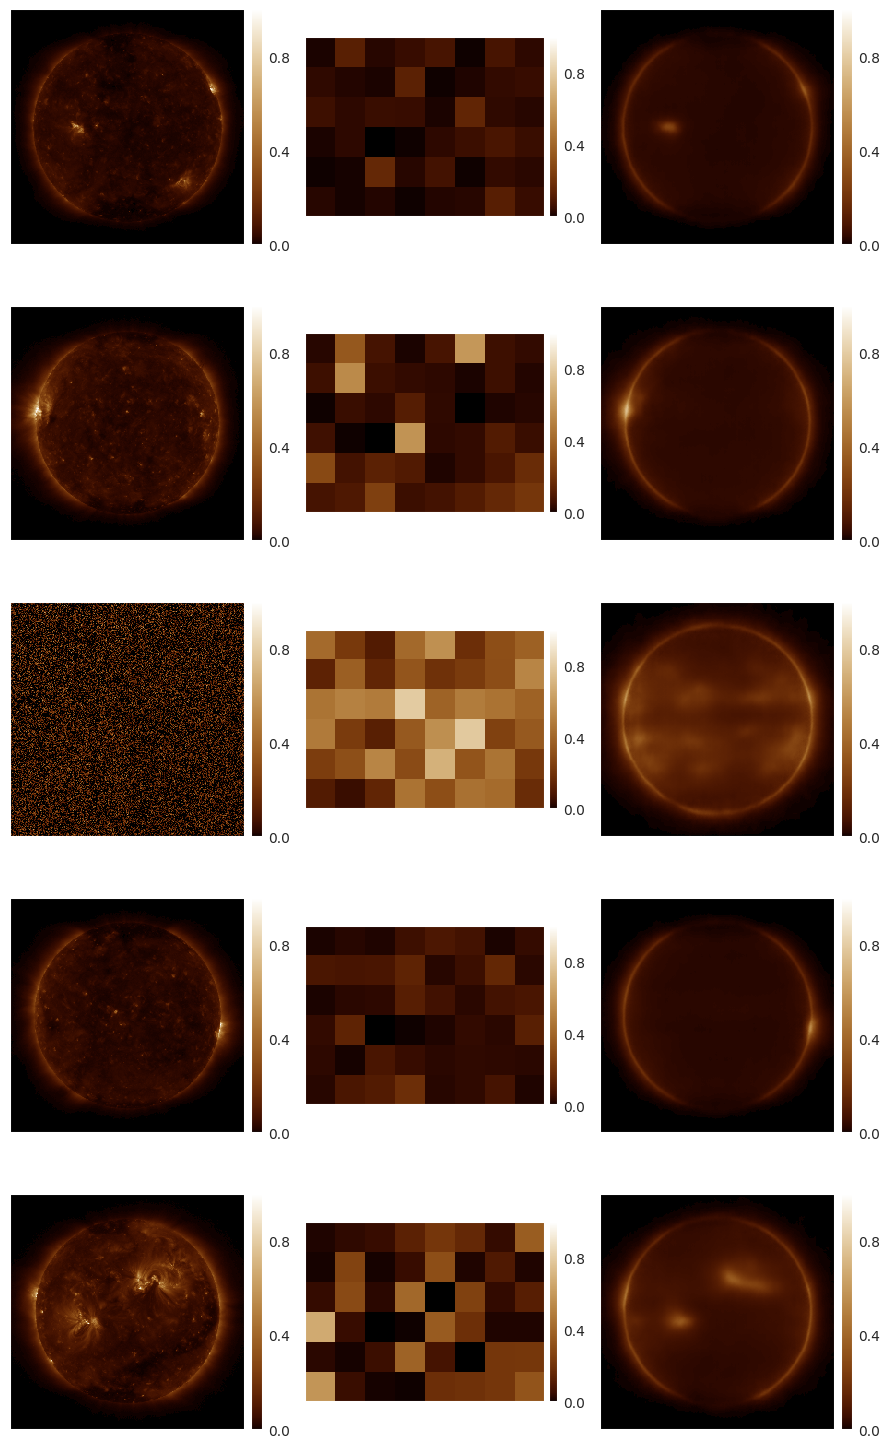

In [10]:
gen_input.take_all = True
example = all_data_gen.sample(5)
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(np.reshape(i[1], [6,8]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1)

## Test the autoencoder with random inputs

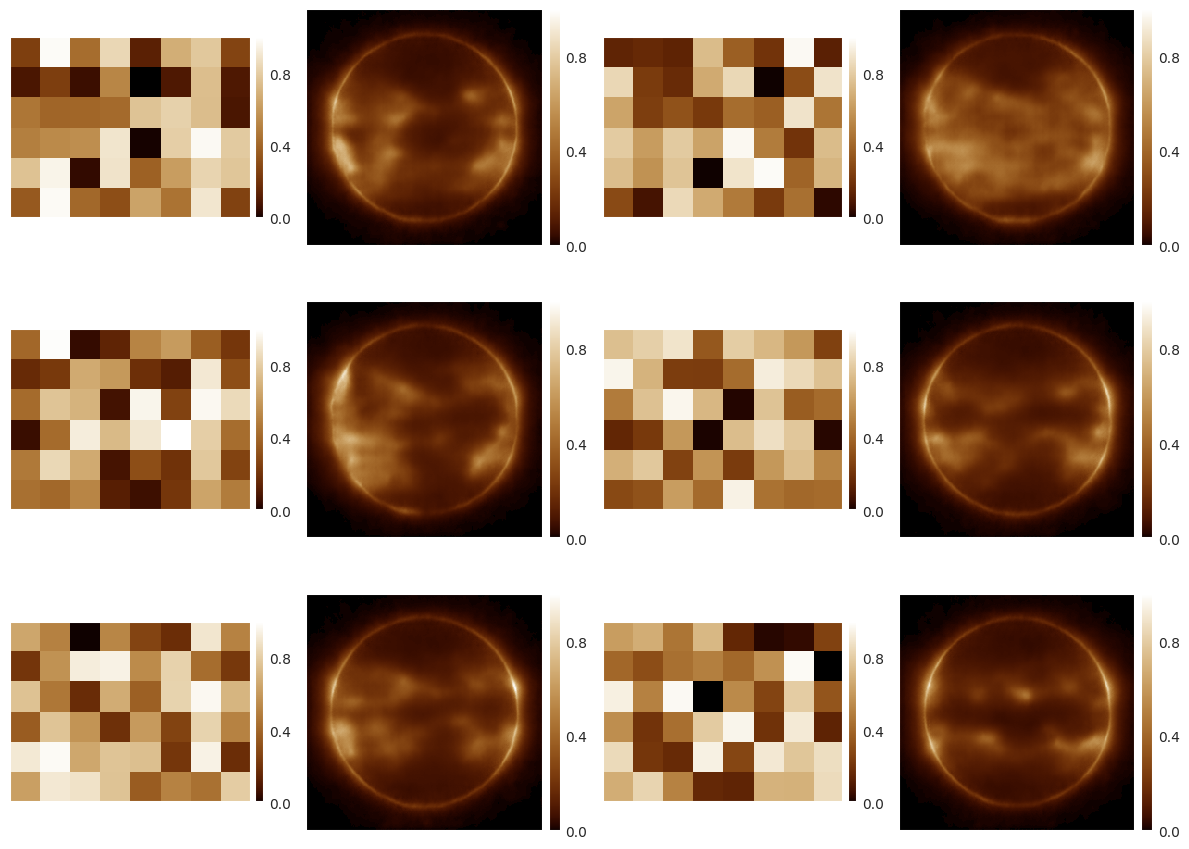

In [11]:
code = np.random.random([6, 48])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [6,8]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=4)